### Loading the data

In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.core.display import display
from sklearn.feature_extraction import stop_words
from sklearn.metrics import jaccard_score, pairwise_distances_chunked, mean_squared_error, mean_absolute_error

In [323]:
#importing the raw data
recipes_raw = pd.read_csv("./Data/RAW_recipes.csv")
interactions_raw = pd.read_csv("./Data/RAW_interactions.csv")

In [324]:
display(recipes_raw.head(5))
print("shape:",recipes_raw.shape)

display(interactions_raw.head(5))
print("shape:",interactions_raw.shape)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


shape: (231637, 12)
shape: (1132367, 5)


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [325]:
#make copies so that we don't have to reload the data

df_r = recipes_raw.copy()
df_i = interactions_raw.copy()

df_r = df_r.rename({"id": "recipe_id"}, axis = 1)
#df_r = df_r.set_index("recipe_id")

## Exploratory data analysis and preprocessing

In [326]:
#looking at missing data

is_na = pd.DataFrame((df_r.isna().sum()), columns =["sum_na"])
display(is_na[is_na["sum_na"]!=0])

,sum_na
name,1
description,4979


In [327]:
#drop the one na row where the title of the recipe is missing
df_r.drop(df_r[df_r["name"].isna()].index, inplace =True)
df_r.shape

(231636, 12)

In [328]:
# add dummy variable to indicate missing descriptions
df_r["description_na"] = df_r["description"].isna().apply(lambda x: 1 if x == True else 0)

df_r["description"] = df_r["description"].fillna("NA")

print("# rows where description is missing:", len(df_r[df_r["description_na"] == 1]), "|| No mistakes?", len(df_r[df_r["description_na"] == 1]) == len(df_r[df_r["description"] == "NA"]))

# rows where description is missing: 4979 || No mistakes? True


#### Preprocess Minutes column

In [329]:
display(df_r[df_r["minutes"]==df_r["minutes"].min()])
display(df_r.nlargest(10, 'minutes'))

# let's deal with the 1094 recipes which don't have any minutes later

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,description_na
5,apple a day milk shake,5289,0,1533,1999-12-06,"['15-minutes-or-less', 'time-to-make', 'course...","[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",NA,"['milk', 'vanilla ice cream', 'frozen apple ju...",4,1
2451,acorn magic delights,1712,0,1534,1999-10-01,"['15-minutes-or-less', 'time-to-make', 'course...","[148.4, 15.0, 28.0, 2.0, 3.0, 21.0, 4.0]",13,"['melt the butter or margarine over low heat',...",NA,"['butter', 'brown sugar', 'pecans', 'all-purpo...",7,1
3079,albanian byrek,4880,0,1534,1999-11-24,"['15-minutes-or-less', 'time-to-make', 'course...","[354.4, 42.0, 25.0, 59.0, 37.0, 37.0, 2.0]",14,"['prepare the dough with flour , 1 and a half ...","the directions to this are vague, but maybe yo...","['flour', 'water', 'oil', 'vinegar', 'salt', '...",9,0
3193,alfredo sauce with pasta,3258,0,1534,1999-10-10,"['15-minutes-or-less', 'time-to-make', 'course...","[1902.9, 287.0, 5.0, 140.0, 104.0, 583.0, 3.0]",8,['cook noodles or fettuccine according to pack...,NA,"['butter', 'heavy cream', 'parmesan cheese', '...",6,1
3259,alice s doughnuts,2284,0,1752,1999-10-18,"['15-minutes-or-less', 'time-to-make', 'course...","[107.3, 6.0, 20.0, 3.0, 3.0, 10.0, 4.0]",17,"['in a large bowl , beat the eggs until foamy'...",NA,"['eggs', 'sugar', 'milk', 'shortening', 'vanil...",9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230372,zesty beef and bean wedges,2681,0,1552,1999-09-10,"['15-minutes-or-less', 'time-to-make', 'main-i...","[290.9, 34.0, 0.0, 3.0, 39.0, 43.0, 0.0]",9,"['heat oven to 375', 'combine beef , beans , m...",this was in my local paper today which was sub...,"['ground round', 'chili hot beans', 'southwest...",8,0
230714,zippy cauliflower,7970,0,34879,2000-03-13,"['15-minutes-or-less', 'time-to-make', 'main-i...","[66.0, 1.0, 6.0, 9.0, 10.0, 2.0, 3.0]",12,"['preheat oven to 350f', 'steam cauliflower ju...",NA,"['cauliflower', 'low-fat margarine', 'all-purp...",10,1
230761,zippy tomato sauce,8035,0,56112,2000-03-13,"['15-minutes-or-less', 'time-to-make', 'course...","[73.8, 4.0, 21.0, 27.0, 2.0, 3.0, 3.0]",5,"['melt margarine in a small saucepan', 'add gr...",this is one of my adopted recipes. i have not...,"['margarine', 'green bell pepper', 'onion', 't...",7,0
230854,zucchini tomato casserole,7971,0,28649,2000-03-13,"['15-minutes-or-less', 'time-to-make', 'course...","[49.9, 1.0, 19.0, 2.0, 8.0, 2.0, 2.0]",7,"['preheat oven to 350f', 'steam zucchini until...",NA,"['zucchini', 'pepper', 'chives', 'low-fat marg...",7,1


,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,description_na
144074,no bake granola balls,261647,2147483647,464080,2007-10-26,"['60-minutes-or-less', 'time-to-make', 'course...","[330.3, 23.0, 110.0, 4.0, 15.0, 24.0, 15.0]",9,"['preheat the oven to 350 degrees', 'spread oa...",healthy snacks that kids (and grown ups) will ...,"['rolled oats', 'unsweetened dried shredded co...",8,0
109624,how to preserve a husband,447963,1051200,576273,2011-02-01,"['time-to-make', 'course', 'preparation', 'for...","[407.4, 57.0, 50.0, 1.0, 7.0, 115.0, 5.0]",9,"['be careful in your selection', ""don't choose...","found this in a local wyoming cookbook ""a coll...","['cream', 'peach']",2,0
106563,homemade fruit liquers,291571,288000,553251,2008-03-12,"['time-to-make', 'course', 'main-ingredient', ...","[836.2, 0.0, 333.0, 0.0, 0.0, 0.0, 27.0]",12,"['rinse the fruit or berries , fruit must be c...",this should be a nice easy project for those w...,"['berries', 'vodka', 'granulated sugar']",3,0
38116,celtic druid s honey mead meade metheglin,216215,259260,242729,2007-03-11,"['time-to-make', 'course', 'main-ingredient', ...","[531.0, 0.0, 561.0, 1.0, 1.0, 0.0, 47.0]",18,"['equipement:', 'very large pan - to hold 12 p...","mead, made from fermented honey, was the earli...","['gingerroot', 'lemons, juice and rind of', 'w...",7,0
106963,homemade vanilla,425681,259205,28177,2010-05-16,"['time-to-make', 'preparation', '5-ingredients...","[69.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9,['slice the vanilla beans length-wise and scra...,found this recipe on tammy's blog (http://www....,"['vanilla beans', 'vodka']",2,0
155044,peach brandy,98912,216015,34146,2004-09-01,"['time-to-make', 'course', 'main-ingredient', ...","[3645.3, 3.0, 2040.0, 0.0, 16.0, 0.0, 173.0]",9,"['use only fully ripened , unblemished fruit',...",posted in reply to a message board request for,"['fresh peaches', 'granulated sugar', 'honey',...",4,0
5497,angelica liqueur,70551,201610,59064,2003-09-04,"['weeknight', 'time-to-make', 'course', 'cuisi...","[891.8, 0.0, 906.0, 0.0, 1.0, 0.0, 76.0]",7,"['crush the fennel , aniseed , coriander seeds...",finish off a large meal with a tiny glass of t...,"['fennel seed', 'anise seed', 'coriander seeds...",7,0
177906,rumtopf,12931,187200,5060,2001-10-20,"['weeknight', 'time-to-make', 'course', 'main-...","[11510.6, 10.0, 6543.0, 2.0, 51.0, 5.0, 579.0]",16,"['in a 8 quart stockpot , combine sugar and wa...",rumtopf is a traditional german delicious frui...,"['sugar', 'water', 'golden rum', 'peaches', 'g...",8,0
170999,raspberry liqueur,172114,172810,83093,2006-06-09,"['time-to-make', 'course', 'main-ingredient', ...","[91.5, 0.0, 35.0, 0.0, 0.0, 0.0, 3.0]",7,['rinse the berries & cut into small pieces or...,if you love chambord as i do but suffer sticke...,"['fresh raspberry', 'vodka', 'fine sugar']",3,0
53721,cinnamon extract,153634,172800,208121,2006-01-30,"['time-to-make', 'course', 'preparation', 'for...","[14.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",5,"['put ingredients in container', 'combine', 'p...",a no brainer.. so why didn't i think of it? \r...,"['cinnamon sticks', 'vodka']",2,0


In [330]:
#minutes -> hours to get a better feeling for the time

df_r["hours"] = df_r["minutes"]/60

df_r.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,description_na,hours
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,0,0.916667
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,0,0.500000
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,0,2.166667
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,0,0.750000
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,0,3.166667


In [331]:
#let's have a look at the really long recipes

df_r[df_r["hours"]>24].name

#we see that there are legit recipes which are very long

11                better than sex  strawberries
12              better then bush s  baked beans
50        keep it going  german friendship cake
58                           marijuana  vinegar
81                          red  macaroni salad
                          ...                  
230506                       zesty lemon olives
230741              zippy london broil marinade
230913               zucchini and cheese damper
231355                   zucchini salsa  canned
231573                zuni caf zucchini pickles
Name: name, Length: 2000, dtype: object

In [332]:
#Correct some obvious outliers, but rest of the large recipes are liquors that take months to make

df_r.loc[144074, "minutes"]= 25
df_r.drop(df_r[df_r["name"]=="how to preserve a husband"].index, inplace=True)
df_r.shape

(231635, 14)

(array([2.31634e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([       0.        ,  3579139.41166667,  7158278.82333333,
        10737418.235     , 14316557.64666667, 17895697.05833333,
        21474836.47      , 25053975.88166667, 28633115.29333333,
        32212254.705     , 35791394.11666667]),
 <a list of 10 Patch objects>)

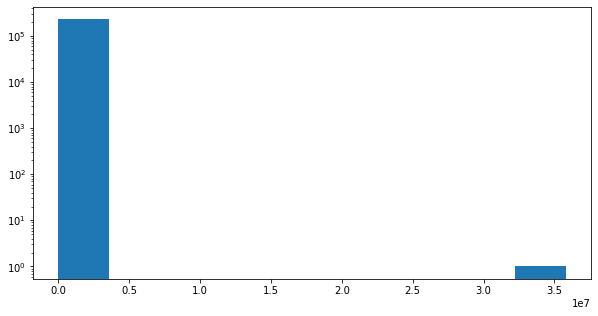

In [333]:
#minutes
plt.figure(figsize=(10,5))
plt.hist(df_r["hours"], log=True)


#### Checking out n_ingredients

count    231635.000000
mean          9.051180
std           3.734783
min           1.000000
25%           6.000000
50%           9.000000
75%          11.000000
max          43.000000
Name: n_ingredients, dtype: float64

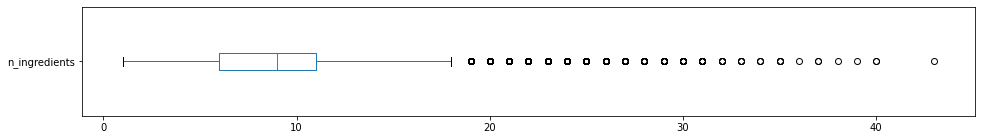

In [334]:
#check number of ingredients
display(df_r.n_ingredients.describe())
df_r["n_ingredients"].plot(kind="box", vert =False, figsize=(16,2))

In [335]:
df_r[df_r['n_ingredients']<=1]

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,description_na,hours
6499,apple cider reduction,521756,155,171084,2015-04-19,"['time-to-make', 'course', 'preparation', 'low...","[14.4, 0.0, 0.0, 8.0, 0.0, 0.0, 1.0]",13,"['in 6-8 quart stock pan , measure out 2 cups ...",i saw a post about this on facebook and gave i...,['apple cider'],1,0,2.583333
13958,baked corn on the cob,434212,35,542159,2010-08-04,"['60-minutes-or-less', 'time-to-make', 'main-i...","[113.3, 2.0, 21.0, 0.0, 8.0, 1.0, 8.0]",2,"['in an oven heated at 350 f , cook corn in hu...",one of my neighbors was telling me this is her...,['corn'],1,0,0.583333
49173,chocolate dirt,425260,5,730126,2010-05-13,"['15-minutes-or-less', 'time-to-make', 'course...","[201.2, 19.0, 91.0, 0.0, 3.0, 37.0, 8.0]",3,"['place chips in a coffee grinder', 'grind unt...","this chocolate ""dirt"" is perfect for dusting c...",['dark chocolate chips'],1,0,0.083333
55087,clotted cream,9043,900,6258,2001-05-19,"['weeknight', 'time-to-make', 'cuisine', 'prep...","[410.6, 67.0, 0.0, 1.0, 4.0, 137.0, 1.0]",6,['cook cream in top of double boiler over simm...,this recipe comes close to the real thing.,['heavy cream'],1,0,15.000000
74549,easter hard boiled eggs,354371,12,1119236,2009-02-06,"['15-minutes-or-less', 'time-to-make', 'course...","[68.9, 7.0, 0.0, 2.0, 12.0, 7.0, 0.0]",9,['place the eggs in a pot with enough cold sal...,"a gruszecki tradition and now ours, is that ea...",['egg'],1,0,0.200000
76587,easy granita,233253,5,226066,2007-06-07,"['15-minutes-or-less', 'time-to-make', 'main-i...","[55.2, 0.0, 49.0, 0.0, 1.0, 0.0, 4.0]",4,['place the grapes or strawberries in the free...,from weight watchers website.,['red seedless grapes'],1,0,0.083333
86040,freezing eggs,153034,35,249074,2006-01-23,"['60-minutes-or-less', 'time-to-make', 'main-i...","[11.9, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0]",37,"['items needed:', 'eggs', 'ziplock bags , vari...",a tried & true method to have eggs in your hou...,['egg'],1,0,0.583333
103771,healthy salt substitute,134711,10,193499,2005-08-24,"['15-minutes-or-less', 'time-to-make', 'course...","[230.4, 3.0, 105.0, 48.0, 19.0, 3.0, 14.0]",4,"['cut up the celery into fairly small pieces',...",i need to change this description again. at f...,['celery'],1,0,0.166667
106369,homemade butter,310,395,1551,1999-09-07,"['weeknight', 'time-to-make', 'course', 'main-...","[68.4, 11.0, 0.0, 0.0, 0.0, 22.0, 0.0]",10,['place the bowl and blade of a food processor...,NA,['heavy cream'],1,1,6.583333
106735,homemade panko japanese bread crumbs,376622,5,157167,2009-06-10,"['15-minutes-or-less', 'time-to-make', 'cuisin...","[199.5, 3.0, 12.0, 21.0, 11.0, 2.0, 12.0]",5,['carefully trim only the brown crust from fre...,"i was cooking with a japanese friend, and she ...",['white bread'],1,0,0.083333


### Include average ratings into recipe df

In [336]:
test = pd.DataFrame(df_i.groupby("recipe_id").count())
test[test["review"]==0]

print("# of recipes involved in interactions:", test.shape)

# of recipes involved in interactions: (231637, 4)


In [337]:
#check how many reviews where given w/o a rating
print("# interactions w/o rating, only review:",len(df_i[df_i["rating"]==0]))

# interactions w/o rating, only review: 60847


In [338]:
#create num_interactions & average ratings column

num_interactions = df_i.groupby("recipe_id")["date"].count()
#only consider the ratings (>0) into the mean, not the reviews w/o ratings
mean_ratings = df_i[df_i["rating"]!=0].groupby("recipe_id")["rating"].mean()

df_rmerged = df_r.join(num_interactions, how="left", on="recipe_id").join(mean_ratings, how="left", on="recipe_id")


print("shape after merging:", df_rmerged.shape)

df_rmerged = df_rmerged.rename(columns ={"date":"num_interactions", "rating":"avg_rating"})
df_rmerged.head()

shape after merging: (231635, 16)


,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,description_na,hours,num_interactions,avg_rating
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,0,0.916667,3,5.000000
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,0,0.500000,4,4.666667
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,0,2.166667,1,4.000000
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,0,0.750000,2,4.500000
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,0,3.166667,1,5.000000


### Create columns for year, month & age

In [339]:
#Preprocess the "submitted" column
df_rmerged["submitted"] = df_rmerged["submitted"].astype(str)

dates = pd.DataFrame(df_rmerged["submitted"].apply(lambda date: date.split("-")).tolist(), index = df_rmerged.index,columns =["year", "month", "day"])

df_rmerged["year"] = dates ["year"]
df_rmerged["month"] = dates["month"]

#create an age column for the recipes
df_rmerged["year"]= df_rmerged["year"].astype(int)
df_rmerged["month"]=df_rmerged["month"].astype(int)
df_rmerged["age"] = (2019-df_rmerged.year)+ df_rmerged.month/12

,recipe_id,minutes,contributor_id,n_steps,n_ingredients,description_na,hours,num_interactions,avg_rating,year,month,age
count,231635.000000,231635.000000,2.316350e+05,231635.000000,231635.000000,231635.000000,2.316350e+05,231635.000000,226589.000000,231635.000000,231635.000000,231635.000000
mean,222013.102187,123.108209,5.534927e+06,9.765519,9.051180,0.021495,1.565681e+02,4.888570,4.580776,2006.388007,6.310709,13.137885
std,141206.137870,1977.767901,9.979184e+07,5.995149,3.734783,0.145028,7.436636e+04,17.532554,0.629448,2.996761,3.429703,3.040214
min,38.000000,0.000000,2.700000e+01,0.000000,1.000000,0.000000,0.000000e+00,1.000000,1.000000,1999.000000,1.000000,1.083333
25%,99943.500000,20.000000,5.690500e+04,6.000000,6.000000,0.000000,3.333333e-01,1.000000,4.333333,2004.000000,3.000000,11.166667
50%,207248.000000,40.000000,1.736140e+05,9.000000,9.000000,0.000000,6.666667e-01,2.000000,4.888889,2007.000000,6.000000,13.000000
75%,333814.000000,65.000000,3.982750e+05,12.000000,11.000000,0.000000,1.083333e+00,4.000000,5.000000,2008.000000,9.000000,15.250000
max,537716.000000,288000.000000,2.002290e+09,145.000000,43.000000,1.000000,3.579139e+07,1613.000000,5.000000,2018.000000,12.000000,21.000000


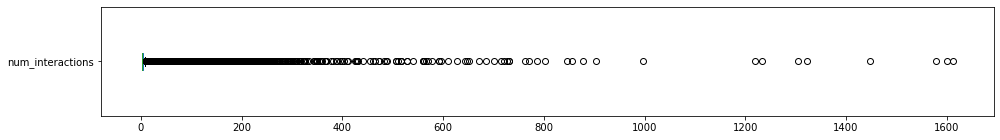

In [340]:
#show most popular recipes

display(df_rmerged.describe())

#display(df_rmerged.nlargest(10, 'num_interactions'))

#One can see that the most popular recipes are also very old
df_rmerged["num_interactions"].plot(kind="box", vert =False, figsize=(16,2))

#### Check out n_steps

n_steps has little outliers. Most of 1step recipes just forgot to add paragraphs in their steps description. We can still use text descriptions for NLP -> don't delete

In [341]:
df_rmerged[df_rmerged['n_steps']==0]

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,description_na,hours,num_interactions,avg_rating,year,month,age
3381,all season bread,176767,90,331268,2006-07-10,"['time-to-make', 'course', 'main-ingredient', ...","[198.8, 11.0, 70.0, 18.0, 5.0, 5.0, 10.0]",0,[],just change the fruit/vegetable in this recipe...,"['flour', 'baking soda', 'salt', 'baking powde...",12,0,1.5,2,4.5,2006,7,13.583333


### Eliminating low quality/low interaction/duplicate recipes

In [342]:
#We want some quality in our recommended systems, no description of steps is bad
df_rmerged.drop(df_rmerged[df_rmerged['n_steps']==0].index, inplace=True)

In [343]:
#remove all recipes which are older/younger than 8 years and have less than 15/10 interactions

index_remove= df_rmerged[(df_rmerged["num_interactions"]<=15) & (df_rmerged["age"]>8.0)]["recipe_id"].index

df_rmerged.drop(index_remove, axis=0, inplace=True)

print("Shape after removing old & inactive recipes:", df_rmerged.shape)

index_remove= df_rmerged[(df_rmerged["num_interactions"]<=10)& (df_rmerged["age"]<=8.0)]["recipe_id"].index

df_rmerged.drop(index_remove, axis=0, inplace=True)

print("Shape after removing newer & inactive recipes:", df_rmerged.shape)

Shape after removing old & inactive recipes: (21913, 19)
Shape after removing newer & inactive recipes: (11151, 19)


In [344]:
#1 step recipes are not inherently bad, often they are just all steps written into one field, but let's filter by interactions

df_rmerged.drop(df_rmerged[(df_rmerged["n_steps"]==1)&(df_rmerged["num_interactions"]==1)].index, axis=0, inplace =True)
print("Shape after removing 1 step recipes w/ low interactions:", df_rmerged.shape)

Shape after removing 1 step recipes w/ low interactions: (11151, 19)


In [345]:
# same for recipes which don't have any time instructions

df_rmerged.drop(df_rmerged[(df_rmerged['minutes']==0)].index, axis=0, inplace=True)
print('Shape after removing 0 minutes interaction w/ low interactions:', df_rmerged.shape)

Shape after removing 0 minutes interaction w/ low interactions: (11103, 19)


In [346]:
#eliminate duplicate recipes through ratings

#do we have duplicate recipe titles?
print("# duplicate recipe titles:",len(df_rmerged["name"])-len(df_rmerged["name"].unique()))

# duplicate recipe titles: 13


In [347]:
def choose_best(interactions, ratings, n_dupl):
    # number of interaction are different -> there exists a maximum
    if((len(interactions) != len(set(interactions)))) :
        return interactions.idxmax(axis=1)
    else:# return the maximum rating or any of the duplicate recipes
        return ratings.idxmax(axis=1)

In [348]:
dupl_recipes = pd.DataFrame(df_rmerged[df_rmerged["name"].duplicated(keep=False)])
dupl_rgrouped= dupl_recipes.groupby('name').groups

to_keep = []

for name in dupl_rgrouped:
    n_dupl = len(dupl_rgrouped[name])
    if(n_dupl == 2):
        index1=dupl_rgrouped[name][0]
        index2=dupl_rgrouped[name][1]
        
        interactions = dupl_recipes.loc[[index1, index2], ['num_interactions']].num_interactions
        ratings = dupl_recipes.loc[[index1, index2], ['avg_rating']].avg_rating
        
        to_keep.append(choose_best(interactions, ratings, n_dupl))
    elif (n_dupl==3):
        index1=dupl_rgrouped[name][0]
        index2=dupl_rgrouped[name][1]
        index3=dupl_rgrouped[name][2]
        
        interactions = dupl_recipes.loc[[index1, index2, index3], ['num_interactions']].num_interactions
        ratings = dupl_recipes.loc[[index1, index2, index3], ['avg_rating']].avg_rating
        to_keep.append(choose_best(interactions, ratings, n_dupl))
    else:
        print("Error")
        break 

df_rmerged.drop(df_rmerged.index.intersection(to_keep), axis=0, inplace=True)
print('Shape after dropping duplicates:', df_rmerged.shape)

Shape after dropping duplicates: (11090, 19)


In [349]:
#there are no recipes with an average rating of 0
print("is 0 ratings:", df_rmerged[df_rmerged["avg_rating"]==0])

is 0 ratings: Empty DataFrame
Columns: [name, recipe_id, minutes, contributor_id, submitted, tags, nutrition, n_steps, steps, description, ingredients, n_ingredients, description_na, hours, num_interactions, avg_rating, year, month, age]
Index: []


In [350]:
#how many recipes don't have any ratings?
print("is na ratings:", df_rmerged["avg_rating"].isna().sum())

df_rmerged.drop(df_rmerged[df_rmerged["avg_rating"].isna()].index, axis=0, inplace =True)
print("Shape after removing recipes w/o ratings:", df_rmerged.shape)

is na ratings: 0
Shape after removing recipes w/o ratings: (11090, 19)


In [351]:
display(df_rmerged.describe())

,recipe_id,minutes,contributor_id,n_steps,n_ingredients,description_na,hours,num_interactions,avg_rating,year,month,age
count,11090.000000,11090.000000,1.109000e+04,11090.000000,11090.000000,11090.000000,1.109000e+04,11090.000000,11090.000000,11090.000000,11090.000000,11090.000000
mean,129217.704328,117.280523,3.310630e+06,9.488638,8.802976,0.020198,3.229312e+03,43.231380,4.699969,2004.445987,6.249594,15.074812
std,112826.619288,1565.250045,7.590735e+07,5.753003,3.664785,0.140685,3.398700e+05,68.649388,0.234700,2.642736,3.457341,2.697202
min,49.000000,1.000000,2.700000e+01,1.000000,1.000000,0.000000,1.666667e-02,11.000000,2.133333,1999.000000,1.000000,2.083333
25%,44069.000000,22.000000,3.150550e+04,6.000000,6.000000,0.000000,3.666667e-01,19.000000,4.592593,2002.000000,3.000000,13.416667
50%,96990.000000,40.000000,6.871500e+04,8.000000,8.000000,0.000000,6.666667e-01,25.000000,4.750000,2004.000000,6.000000,15.416667
75%,179187.250000,70.000000,1.839640e+05,12.000000,11.000000,0.000000,1.166667e+00,41.000000,4.863636,2006.000000,9.000000,17.166667
max,533699.000000,115230.000000,2.001593e+09,82.000000,43.000000,1.000000,3.579139e+07,1613.000000,5.000000,2017.000000,12.000000,21.000000


### Generate an URL for every recipe

In [352]:
df_r["URL"] = df_r.apply(lambda row: "https://www.food.com/recipe/"+" ".join(row["name"].split()).replace(" ", "-") 
                         +"-"+str(row["recipe_id"]), axis=1)

In [353]:
#Check if website exists
# import requests
# from time import sleep

# def website_exists(url):
#     try:
#         request = requests.get(url)
#         if request.status_code == 200:
#             return 1
#         else:
#             return 0
#     except NewConnectionError:
#         return 0
#     except MaxRetryError:
#         print("Max")

### Incuding users into the mix: Creating user-interaction data

In [354]:
df_uactivity = df_i[['recipe_id','user_id', 'rating']]

In [355]:
#Create a user activity dataframe

df_uactivity = df_uactivity.groupby('user_id')['rating'].value_counts().unstack().fillna(0)

cols = list(df_uactivity)
df_uactivity['total_interactions'] = df_uactivity[cols].sum(axis=1)
df_uactivity['total_ratings'] = df_uactivity['total_interactions']-df_uactivity[0]

df_uactivity.head()


rating,0,1,2,3,4,5,total_interactions,total_ratings
user_id,,,,,,,,
1533,0.0,2.0,5.0,1.0,12.0,108.0,128.0,128.0
1535,6.0,1.0,10.0,53.0,248.0,476.0,794.0,788.0
1581,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1634,9.0,0.0,2.0,7.0,18.0,24.0,60.0,51.0
1676,0.0,1.0,0.0,2.0,2.0,26.0,31.0,31.0


### Filter out inactive users

In [356]:
df_uactivity = df_uactivity[df_uactivity['total_interactions']>=7]
df_uactivity.shape

(17099, 8)

#### Create average rating per user

In [357]:
df_uactivity['uavg_rating'] = df_uactivity.iloc[:,1:6].apply(
    lambda row: np.round(np.ma.average(list(range(1,6)), weights = (row[1], row[2], row[3], row[4], row[5])),1), axis = 1)
display(df_uactivity.head())
df_uactivity.shape

c:\users\andi\desktop\data science\mmds\web mining\lab\project\food\webminingrecipeproject\venv\lib\site-packages\numpy\ma\extras.py:631: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


rating,0,1,2,3,4,5,total_interactions,total_ratings,uavg_rating
user_id,,,,,,,,,
1533,0.0,2.0,5.0,1.0,12.0,108.0,128.0,128.0,4.7
1535,6.0,1.0,10.0,53.0,248.0,476.0,794.0,788.0,4.5
1634,9.0,0.0,2.0,7.0,18.0,24.0,60.0,51.0,4.3
1676,0.0,1.0,0.0,2.0,2.0,26.0,31.0,31.0,4.7
1792,0.0,0.0,0.0,5.0,5.0,21.0,31.0,31.0,4.5


(17099, 9)

In [358]:
df_uactivity = df_uactivity.reset_index()
df_uactivity.columns.set_names(None, inplace = True)

### Create filtered interactions df

In [359]:
# 1. Create Filter for interations with filtered df_uactivity -> Only interactions from active users remain

user_filter = pd.merge(df_uactivity[['user_id']], df_i[['recipe_id','user_id', 'rating']], how = 'left', on ='user_id')

display(user_filter.head())
user_filter.shape

,user_id,recipe_id,rating
0,1533,116345,5
1,1533,32907,5
2,1533,14750,5
3,1533,24136,5
4,1533,63598,4


(839520, 3)

In [360]:
# 2. Filter interactions with active recipes -> Only interactions from active users and recipes remain

interactions = pd.merge(df_rmerged[['recipe_id']], user_filter[['recipe_id', 'user_id', 'rating']], on = 'recipe_id', how ='inner')
display(interactions.head())
interactions.shape

,recipe_id,user_id,rating
0,63986,4470,5
1,63986,28649,4
2,63986,37471,5
3,63986,60992,5
4,63986,75497,5


(328795, 3)

Percent of 5 star rating interactions: 77.91%
Percent of 4 star rating interactions: 14.83%
Percent of 3 star rating interactions: 3.27%
Percent of 2 star rating interactions: 1.01%
Percent of 1 star rating interactions: 0.47%
Percent of interactions w/ ratings: 2.5%


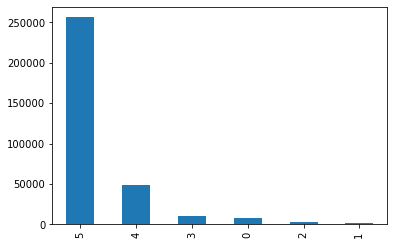

In [361]:
ratings_dist = pd.Series(interactions.rating.value_counts())
ratings_dist.plot.bar()
print(f'Percent of 5 star rating interactions: {round((ratings_dist.loc[5]/len(interactions)*100),2)}%')
print(f'Percent of 4 star rating interactions: {round((ratings_dist.loc[4]/len(interactions)*100),2)}%')
print(f'Percent of 3 star rating interactions: {round((ratings_dist.loc[3]/len(interactions)*100),2)}%')
print(f'Percent of 2 star rating interactions: {round((ratings_dist.loc[2]/len(interactions)*100),2)}%')
print(f'Percent of 1 star rating interactions: {round((ratings_dist.loc[1]/len(interactions)*100),2)}%')
print(f'Percent of interactions w/ ratings: {round((ratings_dist.loc[0]/len(interactions)*100),2)}%')

In [362]:
#Comparison: Interactions w/o filtering by users

#merge recipes dataframe with the filtered user interactions -> result: interactions only with active recipes and active users

interactions1= pd.merge(df_rmerged[['recipe_id']], df_i[['recipe_id', 'user_id', 'rating']], on='recipe_id', how='left')
display(interactions1.head())
interactions1.shape

,recipe_id,user_id,rating
0,63986,60992,5
1,63986,95743,5
2,63986,37471,5
3,63986,92641,5
4,63986,4470,5


(479436, 3)

Percent of 5 star rating interactions: 75.33%
Percent of 4 star rating interactions: 13.35%
Percent of 3 star rating interactions: 3.13%
Percent of 2 star rating interactions: 1.25%
Percent of 1 star rating interactions: 1.12%
Percent of interactions w/ ratings: 5.81%


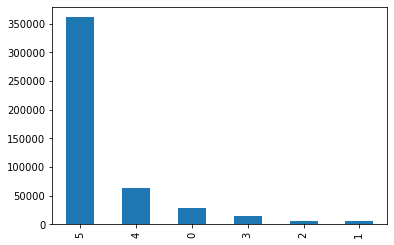

In [363]:
ratings_dist1 = pd.Series(interactions1.rating.value_counts())
ratings_dist1.plot.bar()
print(f'Percent of 5 star rating interactions: {round((ratings_dist1.loc[5]/len(interactions1)*100),2)}%')
print(f'Percent of 4 star rating interactions: {round((ratings_dist1.loc[4]/len(interactions1)*100),2)}%')
print(f'Percent of 3 star rating interactions: {round((ratings_dist1.loc[3]/len(interactions1)*100),2)}%')
print(f'Percent of 2 star rating interactions: {round((ratings_dist1.loc[2]/len(interactions1)*100),2)}%')
print(f'Percent of 1 star rating interactions: {round((ratings_dist1.loc[1]/len(interactions1)*100),2)}%')
print(f'Percent of interactions w/ ratings: {round((ratings_dist1.loc[0]/len(interactions1)*100),2)}%')

In [364]:
def get_rating_dist(ratings_series, length):
    ratings_series.plot.bar()
    print(f'Percent of 5 star rating interactions: {round((ratings_series.loc[5]/len(length)*100),2)}%')
    print(f'Percent of 4 star rating interactions: {round((ratings_series.loc[4]/len(length)*100),2)}%')
    print(f'Percent of 3 star rating interactions: {round((ratings_series.loc[3]/len(length)*100),2)}%')
    print(f'Percent of 2 star rating interactions: {round((ratings_series.loc[2]/len(length)*100),2)}%')
    print(f'Percent of 1 star rating interactions: {round((ratings_series.loc[1]/len(length)*100),2)}%')
    print(f'Percent of interactions w/ ratings: {round((ratings_series.loc[0]/len(length)*100),2)}%')

### Creating recipe_id/user_id sparse matrix

In [365]:
#function to avoid running out of memory (adapted from Chia Chien)

def create_pivot_table(pd_df):
    data = pd_df.values
    #rows = recipes
    rows, row_pos = np.unique(data[:, 0], return_inverse=True)
    #columns = users
    cols, col_pos = np.unique(data[:, 1], return_inverse=True)
    pivot_matrix = np.zeros((len(rows), len(cols)), dtype=data.dtype)
    pivot_matrix[row_pos, col_pos] = data[:, 2]
    print('Matrix shape:', pivot_matrix.shape)
    df_matrix = pd.DataFrame(pivot_matrix, index = rows, columns = cols)
    return df_matrix

In [366]:
df_matrix = create_pivot_table(interactions)
df_matrix

Matrix shape: (11050, 16905)


,1533,1535,1634,1676,1792,1891,1962,2046,2059,2148,...,2001898367,2001906623,2001987473,2002015205,2002084712,2002120722,2002144249,2002151809,2002157583,2002254807
49,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
142,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
153,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
524960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
528131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
530004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## NLP

### Text Preprocessing

In [367]:
## import the libraries
import nltk
import inflect
import re, string, unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [368]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_special(words):
    """Remove special signs like &*"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[-,$()#+&*]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""  
    stopwords = nltk.corpus.stopwords.words('english')
    myStopWords = []
    stopwords.extend(myStopWords)
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def to_lowercase(words):
    """Convert words to lowercase"""
    new_words=[]
    for word in words:
        new_words.append(word.lower())
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    #stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize_lemmatize(words):
    words = remove_special(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    #words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [369]:
def get_processed(data):
    processed = pd.DataFrame(data=[],columns = ['recipe_id', 'content'])
    new_texts = []

    for i in range(0, len(sample)):
        recipe_id = sample['recipe_id'].iloc[i]
        words = nltk.word_tokenize(sample['content'].iloc[i])
        text = ' '.join(normalize_lemmatize(words))
        dfnew = pd.DataFrame([[recipe_id, text]], columns=['recipe_id', 'content'])
        new_texts.append(text)
        processed = processed.append(dfnew,ignore_index = True)

    return processed

In [370]:
pd.unique(interactions['recipe_id'])

array([ 63986,  25775,  58224, ...,  71450, 208429, 196201], dtype=int64)

In [371]:
helper = pd.unique(interactions['recipe_id'])
df_rfiltered = df_rmerged[df_rmerged.recipe_id.isin(helper)]
print(df_rmerged.shape)
df_rfiltered.shape

(11090, 19)


(11050, 19)

In [372]:
def create_input (df, column_names):
    length = len(column_names)
    df_content = df
    df_content['content'] = df.loc[:, (column_names)].apply(lambda texts: ' '.join(texts), axis=1)
    df_content.drop(columns = column_names, inplace = True)
    df_content['content']=df_content['content'].apply(lambda text: ' '.join(text.split()))
    return df_content

In [373]:
#flatten steps data
df_rfiltered.steps = df_rfiltered.loc[:, ('steps')].str.replace("\[", "").str.replace("'", "").str.replace("\]", "").str.replace(",","").copy()

#create content df
df_content = create_input(df_rfiltered[['recipe_id', 'name','description', 'steps']], ['name','description', 'steps'])

df_content.head()


c:\users\andi\desktop\data science\mmds\web mining\lab\project\food\webminingrecipeproject\venv\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\users\andi\desktop\data science\mmds\web mining\lab\project\food\webminingrecipeproject\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\andi\desktop\data science\mmds\web mining\lab\project\food\webminingreci

,recipe_id,content
15,63986,chicken lickin good pork chops here's and old ...
36,25775,how i got my family to eat spinach spinach cas...
43,58224,immoral sandwich filling loose meat just the t...
53,22526,land of nod cinnamon buns i have made this sev...
67,74805,never weep whipped cream i don't know where i ...


In [374]:
sample = df_content.sample(n=1000, replace=False, random_state=42)\
                 .reset_index()\
                 .drop(columns=['index'])
sample.head()

,recipe_id,content
0,410095,starbucks pumpkin bread my favorite pumpkin br...
1,53081,rockin rice pudding tyler florence knows how t...
2,88348,mean chef s yucatan style chicken lime and orz...
3,27000,creamy apple dessert easy dessert. preheat ove...
4,190896,sesame snow peas this is just too good. to de-...


In [375]:
processed = get_processed(sample)
processed.head()

,recipe_id,content
0,410095,starbucks pumpkin bread favorite pumpkin bread...
1,53081,rockin rice pudding tyler florence know use le...
2,88348,mean chef yucatan style chicken lime orzo soup...
3,27000,creamy apple dessert easy dessert preheat 350f...
4,190896,sesame snow peas good destem peas pinch stem e...


In [376]:
#add some stopwords
new_stopwords = ['.', '\"', '\'', ':', '(', ')', ',', '-', 'etc', '1', '/', '2', '3', '\'s', '\'\'''','``', '!' ]
stop_words.extend(new_stopwords)


AttributeError: module 'sklearn.feature_extraction._stop_words' has no attribute 'extend'

In [ ]:
df_content['content']=df_content['content'].apply(lambda text: [word for word in word_tokenize(text) if word not in stop_words])

df_content.head()

In [ ]:
#import spacy
#nlp = spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner'])

In [ ]:
#test = df_content.iloc[20:30]
#test['content']= test['content'].apply(lambda text: ' '.join(map(str, text)))
#test['content']= test['content'].apply(lambda text: [word.lemma_ for word in nlp(text)])
#test

### Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def get_cos_sim_matrix(processed):
    tfidf = TfidfVectorizer(stop_words='english')
    processed['content'] = processed['content'].fillna('')
    tfidf_matrix = tfidf.fit_transform(processed['content'])
    svd = TruncatedSVD(n_components=10, random_state=42)
    tfidf_truncated = svd.fit_transform(tfidf_matrix) 
    cosine_sim = cosine_similarity(tfidf_truncated,tfidf_truncated)
    return cosine_sim

In [ ]:
cosine_sim = get_cos_sim_matrix(processed)
cosine_sim.shape

In [ ]:
def get_recommendation_cos(processed, interactions, recipe_id, user_id, cosine_sim, k):
    df_sim = pd.DataFrame(cosine_sim, index=processed['recipe_id'], columns=processed['recipe_id'])
    #adjust to sparse matrix
    user_rids = interactions[interactions['user_id']==user_id]['recipe_id'].values
    df_row = df_sim.loc[df_sim.index==recipe_id]
    df_user = df_row[user_rids]
    results = list(zip(list(df_user.columns), list(df_user.values[0])))
    results_ordered = sorted(results, key=lambda x: x[1], reverse=True)
    results_topk = np.array(results_ordered[1:k+1])
    return results_topk[:,0]

def predict_rating(interactions, user_id, recipe_ids):
    scores = []
    for rid in recipe_ids:
        score = interactions.loc[(interactions.user_id==user_id) & (interactions.recipe_id==rid)]['rating']
        scores.append(score.values[0])
        return np.mean(scores)

def get_results_cos(processed, interactions, recipe, recipe_id, user_id, cosine_sim,k):
    actual = interactions.loc[(interactions.user_id==user_id) & (interactions.recipe_id==recipe_id)]['rating'].values[0]
    recipe_ids = get_recommendation_cos(processed,interactions,recipe_id,user_id,cosine_sim,k)
    prediction = predict_rating(interactions, user_id, recipe_ids)
    return actual, prediction

In [ ]:
print(interactions.head())
def get_interaction_processed(processed, interactions):
  interactions_processed = interactions.loc[interactions.recipe_id.isin(processed.recipe_id)]\
                           .reset_index()\
                           .drop(columns=['index'])
  return interactions_processed

interactions_processed = get_interaction_processed(processed, interactions)
interactions_processed.head()

In [ ]:
def get_coverage(processed, interactions, recipe, cosine_sim,k):
    interactions_processed = get_interaction_processed(processed, interactions)
    uid_sample = interactions_processed['user_id'].values
    rid_sample = interactions_processed['recipe_id'].values

    all_rids = interactions_processed['recipe_id'].unique()
    pred_rids = []

    for i in range(len(interactions_processed)):
        try:
          recipe_ids = get_recommendation_cos(processed,
                                                interactions_processed,
                                                rid_sample[i],
                                                uid_sample[i],
                                                cosine_sim,
                                                k)
          pred_rids += list(recipe_ids)
        except:
          next
    pred_bids = np.array(list(set(pred_rids)))
    return len(pred_bids)/len(all_rids)

In [ ]:
uid_sample = interactions_processed['user_id'].values
rid_sample = interactions_processed['recipe_id'].values
print(uid_sample)
print(rid_sample)
predictions_cos = []
actual_cos = []
print(interactions_processed.head())
print(processed.head())

for i in range(len(interactions_processed)):
    try:
        act, pred = get_results_cos(processed,
                                    interactions_processed,
                                    df_r,
                                    rid_sample[i],
                                    uid_sample[i],
                                    cosine_sim,
                                    5)
        predictions_cos.append(pred)
        actual_cos.append(act)
    except:
        next

In [ ]:
print(predictions_cos)

In [ ]:
rmse_cos = mean_squared_error(predictions_cos, actual_cos)**0.5
mae_cos = mean_absolute_error(predictions_cos, actual_cos)
print(f'RMSE: {rmse_cos}, MAE: {mae_cos}')

In [380]:
cov_cos = get_coverage(processed,interactions,df_r,cosine_sim,5)
print(f'coverage: {cov_cos}')

coverage: 0.997


### Tfidf Vectorization

In [ ]:

tfidf_vectorizer = TfidfVectorizer()

In [ ]:
df_content['content'] = [' '.join(text) for text in df_content['content'].values]

In [ ]:
df_content.loc[78,['content']]

In [ ]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df_content['content'])

In [ ]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index = df_content.index.tolist())

### Word Embedding

In [ ]:
import gensim.downloader as api

In [ ]:
model = api.load("glove-wiki-gigaword-50")

#### Embed the steps text

In [ ]:
df_rmerged.ingredients =df_r.ingredients
ingredient_list = []
for e in df_rmerged.ingredients.values:
    ingredient_list.extend(eval(e[1:-1]))
    


## Archive

In [ ]:
# plot some distributions
columns =["num_interactions", "avg_rating", "age", "hours", "n_steps", "n_ingredients"]

fig, axes = plt.subplots(6, 1, figsize=(10,30))
i=0
for c in columns:
    axes[i].set_title(c)
    axes[i].hist(df_rmerged[c], log = True)
    i+=1


In [ ]:
# df_rmerged.ingredients = df_r.ingredients
# df_rmerged.ingredients= df_rmerged.ingredients.str.replace("\[", "").str.replace("'", "").str.replace("\]", "").str.replace(",","")


In [ ]:
# count_vectorizer = CountVectorizer(tokenizer = lambda x: x.split(" "), stop_words ="english", binary=True)
# matrix = count_vectorizer.fit_transform(df_rmerged["ingredients"])

In [ ]:
# m=matrix.toarray()
# m.shape

In [ ]:
# sim_ingredients= next(pairwise_distances_chunked(m, metric="jaccard", n_jobs=-1))

In [ ]:

# i=0
# for chunk in pairwise_distances_chunked(m, metric="jaccard", n_jobs=-1):
#     if i= 0:
#         sim_ingredients= chunk
#         i=1
#         elif:
#             sim_ingredients = np.append(sim_ingredients, chunk, axis=0)

In [ ]:
# sim_ingredients=[]

# x =np.array([[1,2,3,4],[1,2,3,4]])
# sim_ingredients = np.append(x, ([[4,6,7,8],[4,5,6,7]]), axis=0)
# sim_ingredients =np.append(sim_ingredients, ([[4,6,7,8],[4,5,6,7]]), axis=0)
# sim_ingredients